# Import Libaries

In [1]:
# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


#model selection
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Add,Dropout, Dense, Activation, ZeroPadding2D, \
BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D


#preprocess.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Input
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
import PIL
import PIL.Image

import glob   
import shutil


# Splitting Data

In [2]:
# Define the base, training, and testing directories
data_dir = os.curdir + "/Furniture_Data"
training_dir = os.curdir + '/Train'
testing_dir = os.curdir + '/Test'

# Set the ratio of training to testing data
train_test_ratio = 0.8 

def split_dataset_into_test_and_train_sets(all_data_dir=data_dir, training_data_dir=training_dir,
                                           testing_data_dir=testing_dir, train_test_ratio=0.8):
    # Ensure the testing and training directories exist
    if not os.path.exists(training_data_dir):
        os.makedirs(training_data_dir)

    if not os.path.exists(testing_data_dir):
        os.makedirs(testing_data_dir)

    num_training_files = 0
    num_testing_files = 0

    # Walk through the directory structure
    for type_dir in os.listdir(all_data_dir):
        type_path = os.path.join(all_data_dir, type_dir)
        if os.path.isdir(type_path):  # Ensure it's a directory
            for style_dir in os.listdir(type_path):
                style_path = os.path.join(type_path, style_dir)
                if os.path.isdir(style_path):  # Check if it's a directory
                    # Create corresponding training and testing directories
                    training_style_dir = os.path.join(training_data_dir, type_dir, style_dir)
                    testing_style_dir = os.path.join(testing_data_dir, type_dir, style_dir)
                    os.makedirs(training_style_dir, exist_ok=True)
                    os.makedirs(testing_style_dir, exist_ok=True)

                    # Get all JPEG files in the current style directory
                    file_list = glob.glob(os.path.join(style_path, '*.jpg'))

                    print(f"{type_dir} - {style_dir} has {len(file_list)} images")
                    random_set = np.random.permutation(file_list)

                    # Split the files into training and testing sets
                    train_list = random_set[:int(len(random_set) * train_test_ratio)]
                    test_list = random_set[int(len(random_set) * train_test_ratio):]

                    # Copy files to the respective directories
                    for file_path in train_list:
                        shutil.copy(file_path, training_style_dir)
                        num_training_files += 1

                    for file_path in test_list:
                        shutil.copy(file_path, testing_style_dir)
                        num_testing_files += 1

    print(f"Processed {num_training_files} training files.")
    print(f"Processed {num_testing_files} testing files.")

# Example function call
split_dataset_into_test_and_train_sets()


beds - Asian has 52 images
beds - Beach has 51 images
beds - Contemporary has 1953 images
beds - Craftsman has 188 images
beds - Eclectic has 22 images
beds - Farmhouse has 91 images
beds - Industrial has 61 images
beds - Mediterranean has 75 images
beds - Midcentury has 130 images
beds - Modern has 380 images
beds - Rustic has 239 images
beds - Scandinavian has 33 images
beds - Southwestern has 49 images
beds - Traditional has 1397 images
beds - Transitional has 1719 images
beds - Tropical has 55 images
beds - Victorian has 83 images
chairs - Asian has 381 images
chairs - Beach has 186 images
chairs - Contemporary has 4608 images
chairs - Craftsman has 210 images
chairs - Eclectic has 201 images
chairs - Farmhouse has 640 images
chairs - Industrial has 534 images
chairs - Mediterranean has 187 images
chairs - Midcentury has 3585 images
chairs - Modern has 1788 images
chairs - Rustic has 304 images
chairs - Scandinavian has 216 images
chairs - Southwestern has 95 images
chairs - Tradit

# Data Pre-processing

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the common image size to the most frequent size in the dataset
image_size = 350  # Use the most common resolution for minimal distortion
batch_size = 64  # Maintain a batch size of 64 for optimal GPU utilization

# Initialize ImageDataGenerators
# Only rescale is needed as all images are RGB and have the same number of channels
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,  # Reduced to 0.2 for smaller shifts at a larger resolution
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,  # Slightly increased to allow for more variation
    fill_mode='nearest',
    horizontal_flip=True,
    validation_split=0.25  # Using 25% of the training data for validation
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25
)

test_data_gen = ImageDataGenerator(
    rescale=1./255
)

# Define paths to your training and testing directories
training_dir = './Train'
testing_dir = './Test'

# Setup data generators
train_generator = train_data_gen.flow_from_directory(
    training_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

valid_generator = val_datagen.flow_from_directory(
    training_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_data_gen.flow_from_directory(
    testing_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 65295 images belonging to 6 classes.
Found 21761 images belonging to 6 classes.
Found 34715 images belonging to 6 classes.


In [4]:
# Fetch batches of images
train_X, train_Y = next(train_generator)
test_X, test_Y = next(test_generator)

# If you indeed need to reshape the arrays for a specific model requirement:
nsamples, nx, ny, nrgb = train_X.shape
train_X = train_X.reshape((nsamples, nx*ny*nrgb))

nsamples2, nx2, ny2, nrgb2 = test_X.shape
test_X = test_X.reshape((nsamples2, nx2*ny2*nrgb2))

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming train_X and test_X are already loaded and reshaped to flat vectors from your previous code
# Convert categorical labels to a single label index for scikit-learn compatibility
train_labels = np.argmax(train_Y, axis=1)
test_labels = np.argmax(test_Y, axis=1)

# Initialize and train the RandomForest classifier
baseRandomForestClassifier = RandomForestClassifier()
baseRandomForestClassifier.fit(train_X, train_labels)

# Predict using the trained model
y_pred = baseRandomForestClassifier.predict(test_X)

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)
print("Randomforest Accuracy:", accuracy)


Randomforest Accuracy: 0.015625


In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Assuming train_X and test_X are already loaded and reshaped to flat vectors from your previous code
# Convert categorical labels to a single label index for scikit-learn compatibility
train_labels = np.argmax(train_Y, axis=1)
test_labels = np.argmax(test_Y, axis=1)

# Initialize and train the KNeighbors classifier
baseKNN = KNeighborsClassifier()
baseKNN.fit(train_X, train_labels)

# Predict using the trained model
y_pred = baseKNN.predict(test_X)

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)
print("KNN Accuracy:", accuracy)


KNN Accuracy: 0.09375


In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Assuming train_X and test_X are already loaded and reshaped to flat vectors from your previous code
# Convert categorical labels to a single label index for scikit-learn compatibility
train_labels = np.argmax(train_Y, axis=1)
test_labels = np.argmax(test_Y, axis=1)

# Initialize and train the Decision Tree classifier
nb = DecisionTreeClassifier()
nb.fit(train_X, train_labels)

# Predict using the trained model
y_pred = nb.predict(test_X)

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)
print("DecisionTree Accuracy:", accuracy)


DecisionTree Accuracy: 0.125


# CNN Base Model

In [5]:
def get_base_model(image_size=350, num_classes=6):
    baseModel = Sequential()
    
    # Explicit Input layer
    baseModel.add(Input(shape=(image_size, image_size, 3)))
    
    # First convolutional layer
    baseModel.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'))
    
    # Pooling layer
    baseModel.add(MaxPooling2D(pool_size=(2,2)))

    # Additional convolutional and pooling layers
    baseModel.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
    baseModel.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    baseModel.add(Conv2D(filters=96, kernel_size=(3,3), padding='Same', activation='relu'))
    baseModel.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    baseModel.add(Conv2D(filters=96, kernel_size=(3,3), padding='Same', activation='relu'))
    baseModel.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    # Flattening the output of the convolutional layers to feed into the dense layer
    baseModel.add(Flatten())

    # Dense layer
    baseModel.add(Dense(512, activation='relu'))

    # Output layer with units equal to the number of categories
    baseModel.add(Dense(num_classes, activation='softmax'))

    # Compile the model with updated optimizer syntax
    baseModel.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return baseModel

# Example of initializing the model
model = get_base_model(image_size=350, num_classes=6)


## Fit non-balanced dataset to model

In [ ]:
# Initialize the model
rawBaseModel = get_base_model(image_size=350, num_classes=6)  # Ensure to pass image_size here if different from default

# Training the model using the correct data generators
rawBaseHistory = rawBaseModel.fit(
    train_generator,
    steps_per_epoch=max(1, train_generator.samples // batch_size),  # Ensures at least 1 step
    validation_data=valid_generator,
    validation_steps=max(1, valid_generator.samples // batch_size),  # Ensures at least 1 step
    epochs=20
)

Epoch 1/20
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 3014s 3s/step - accuracy: 0.5376 - loss: 1.2605 - val_accuracy: 0.7739 - val_loss: 0.6356
Epoch 2/20
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 304us/step - accuracy: 0.8750 - loss: 0.4335 - val_accuracy: 0.6452 - val_loss: 0.7792
Epoch 3/20
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2983s 3s/step - accuracy: 0.7856 - loss: 0.6060 - val_accuracy: 0.8330 - val_loss: 0.4824
Epoch 4/20
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 243us/step - accuracy: 0.7500 - loss: 0.6598 - val_accuracy: 0.8710 - val_loss: 0.3688
Epoch 5/20
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2949s 3s/step - accuracy: 0.8291 - loss: 0.4861 - val_accuracy: 0.8044 - val_loss: 0.6090
Epoch 6/20
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 260us/step - accuracy: 0.9219 - loss: 0.3576 - val_accuracy: 0.8065 - val_loss: 0.4237
Epoch 7/20
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2966s 3s/step - accuracy: 0.8492 - loss: 0.4337 - val_accuracy: 0.8607 - val_loss: 0.3969
Epoch 8/20
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 250us/step - accuracy: 0.8438 -

In [3]:
def CNN_lR_batch(learning_rate, num_classes):
    model = Sequential()
    
    # Explicit Input layer
    model.add(Input(shape=(350, 350, 3)))
    
    # First convolutional layer
    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'))
    
    # Pooling layer
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Additional convolutional and pooling layers
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(Conv2D(filters=96, kernel_size=(3,3), padding='Same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(Conv2D(filters=96, kernel_size=(3,3), padding='Same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    # Flattening the output of the convolutional layers to feed into the dense layer
    model.add(Flatten())

    # Dense layer
    model.add(Dense(512, activation='relu'))

    # Output layer with units equal to the number of categories
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model with updated optimizer syntax
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model



In [5]:
models = []
lr_boundary = [1e-5, 1e-4,1e-3,1e-2]

escape_for_loop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, restore_best_weights=True)

train32_generator = train_data_gen.flow_from_directory(
    training_dir,
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

valid32_generator = val_datagen.flow_from_directory(
    training_dir,
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test32_generator = test_data_gen.flow_from_directory(
    testing_dir,
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

for learning_rate in lr_boundary:
    model = CNN_lR_batch(learning_rate, 6)
    tracking = model.fit(
    train32_generator,
    steps_per_epoch=train32_generator.n // 32,
    validation_data=valid32_generator,
    validation_steps=valid32_generator.n // 32,
    epochs=20,
    verbose=1, callbacks=[escape_for_loop]
    )

    plt.plot(tracking.history['accuracy'])
    plt.plot(tracking.history['val_accuracy'])
    plt.title('Accuracy with ' + str(learning_rate) + ' learning rate and ' + str(batch_size) +' batch size')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'test'])
    plt.show()
    models.append(model)
            
        
        

Found 64827 images belonging to 6 classes.
Found 21607 images belonging to 6 classes.
Found 32470 images belonging to 6 classes.
Epoch 1/20


C:\Users\ROG\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()

KeyboardInterrupt



(The result for the 32 batch size acidentally removed, so that saved result is demonstrated here)
Found 54019 images belonging to 6 classes.
Found 18004 images belonging to 6 classes.
Found 18059 images belonging to 6 classes.
Epoch 1/20
1688/1688 [==============================] - 3588s 2s/step - loss: 1.2051 - accuracy: 0.5319 - val_loss: 0.9553 - val_accuracy: 0.6408
Epoch 2/20
1688/1688 [==============================] - 3361s 2s/step - loss: 1.0051 - accuracy: 0.6247 - val_loss: 0.9068 - val_accuracy: 0.6549
Epoch 3/20
1688/1688 [==============================] - 3543s 2s/step - loss: 0.9018 - accuracy: 0.6681 - val_loss: 0.7738 - val_accuracy: 0.7079
Epoch 4/20
1688/1688 [==============================] - 3361s 2s/step - loss: 0.8253 - accuracy: 0.6991 - val_loss: 0.7508 - val_accuracy: 0.7245
Epoch 5/20
1688/1688 [==============================] - 3397s 2s/step - loss: 0.7692 - accuracy: 0.7207 - val_loss: 0.6627 - val_accuracy: 0.7612
Epoch 6/20
1688/1688 [==============================] - 3363s 2s/step - loss: 0.7248 - accuracy: 0.7399 - val_loss: 0.6114 - val_accuracy: 0.7753
Epoch 7/20
1688/1688 [==============================] - 3449s 2s/step - loss: 0.6898 - accuracy: 0.7525 - val_loss: 0.5995 - val_accuracy: 0.7891
Epoch 8/20
1688/1688 [==============================] - 3472s 2s/step - loss: 0.6556 - accuracy: 0.7657 - val_loss: 0.6115 - val_accuracy: 0.7749
Epoch 9/20
1688/1688 [==============================] - 3635s 2s/step - loss: 0.6271 - accuracy: 0.7766 - val_loss: 0.5407 - val_accuracy: 0.8043
Epoch 10/20
1688/1688 [==============================] - 3509s 2s/step - loss: 0.6139 - accuracy: 0.7818 - val_loss: 0.5622 - val_accuracy: 0.7977
Epoch 11/20
1688/1688 [==============================] - 3374s 2s/step - loss: 0.5900 - accuracy: 0.7904 - val_loss: 0.5436 - val_accuracy: 0.8058
Epoch 12/20
1688/1688 [==============================] - 3468s 2s/step - loss: 0.5684 - accuracy: 0.7981 - val_loss: 0.5282 - val_accuracy: 0.8126
Epoch 13/20
1688/1688 [==============================] - 3425s 2s/step - loss: 0.5543 - accuracy: 0.8054 - val_loss: 0.5273 - val_accuracy: 0.8096
Epoch 14/20
1688/1688 [==============================] - 3529s 2s/step - loss: 0.5402 - accuracy: 0.8095 - val_loss: 0.4850 - val_accuracy: 0.8317
Epoch 15/20
1688/1688 [==============================] - 3562s 2s/step - loss: 0.5300 - accuracy: 0.8148 - val_loss: 0.4873 - val_accuracy: 0.8320
Epoch 16/20
1688/1688 [==============================] - 3585s 2s/step - loss: 0.5153 - accuracy: 0.8202 - val_loss: 0.4922 - val_accuracy: 0.8264
Epoch 17/20
1688/1688 [==============================] - 3533s 2s/step - loss: 0.5080 - accuracy: 0.8220 - val_loss: 0.4932 - val_accuracy: 0.8278
Epoch 18/20
1688/1688 [==============================] - 3471s 2s/step - loss: 0.4937 - accuracy: 0.8271 - val_loss: 0.4769 - val_accuracy: 0.8421
Epoch 19/20
1688/1688 [==============================] - 3518s 2s/step - loss: 0.4830 - accuracy: 0.8333 - val_loss: 0.4836 - val_accuracy: 0.8340
Epoch 20/20
1688/1688 [==============================] - 3462s 2s/step - loss: 0.4772 - accuracy: 0.8347 - val_loss: 0.4761 - val_accuracy: 0.8324

Epoch 1/20
1688/1688 [==============================] - 3416s 2s/step - loss: 0.9661 - accuracy: 0.6346 - val_loss: 0.6776 - val_accuracy: 0.7481
Epoch 2/20
1688/1688 [==============================] - 3410s 2s/step - loss: 0.6460 - accuracy: 0.7675 - val_loss: 0.5569 - val_accuracy: 0.8032
Epoch 3/20
1688/1688 [==============================] - 3339s 2s/step - loss: 0.5254 - accuracy: 0.8152 - val_loss: 0.4630 - val_accuracy: 0.8390
Epoch 4/20
1688/1688 [==============================] - 3375s 2s/step - loss: 0.4702 - accuracy: 0.8345 - val_loss: 0.4451 - val_accuracy: 0.8447
Epoch 5/20
1688/1688 [==============================] - 3552s 2s/step - loss: 0.4267 - accuracy: 0.8521 - val_loss: 0.4388 - val_accuracy: 0.8532
Epoch 6/20
1688/1688 [==============================] - 3424s 2s/step - loss: 0.3913 - accuracy: 0.8665 - val_loss: 0.3897 - val_accuracy: 0.8694
Epoch 7/20
1688/1688 [==============================] - 3469s 2s/step - loss: 0.3681 - accuracy: 0.8743 - val_loss: 0.4237 - val_accuracy: 0.8536
Epoch 8/20
1688/1688 [==============================] - 3389s 2s/step - loss: 0.3457 - accuracy: 0.8830 - val_loss: 0.3841 - val_accuracy: 0.8733
Epoch 9/20
1688/1688 [==============================] - 3588s 2s/step - loss: 0.3277 - accuracy: 0.8894 - val_loss: 0.3977 - val_accuracy: 0.8632
Epoch 10/20
1688/1688 [==============================] - 3391s 2s/step - loss: 0.3153 - accuracy: 0.8919 - val_loss: 0.3428 - val_accuracy: 0.8801
Epoch 11/20
1688/1688 [==============================] - 3424s 2s/step - loss: 0.2975 - accuracy: 0.8986 - val_loss: 0.3283 - val_accuracy: 0.8910
Epoch 12/20
1688/1688 [==============================] - 3380s 2s/step - loss: 0.2864 - accuracy: 0.9033 - val_loss: 0.3154 - val_accuracy: 0.8952
Epoch 13/20
1688/1688 [==============================] - 3510s 2s/step - loss: 0.2784 - accuracy: 0.9047 - val_loss: 0.3266 - val_accuracy: 0.8898
Epoch 14/20
1688/1688 [==============================] - 3485s 2s/step - loss: 0.2717 - accuracy: 0.9073 - val_loss: 0.3541 - val_accuracy: 0.8774
Epoch 15/20
1688/1688 [==============================] - 3628s 2s/step - loss: 0.2559 - accuracy: 0.9124 - val_loss: 0.3047 - val_accuracy: 0.8964
Epoch 16/20
1688/1688 [==============================] - 3432s 2s/step - loss: 0.2466 - accuracy: 0.9163 - val_loss: 0.3606 - val_accuracy: 0.8788
Epoch 17/20
1688/1688 [==============================] - 3594s 2s/step - loss: 0.2454 - accuracy: 0.9174 - val_loss: 0.2862 - val_accuracy: 0.9037
Epoch 18/20
1688/1688 [==============================] - 3442s 2s/step - loss: 0.2373 - accuracy: 0.9189 - val_loss: 0.3313 - val_accuracy: 0.8876
Epoch 19/20
1688/1688 [==============================] - 3513s 2s/step - loss: 0.2277 - accuracy: 0.9221 - val_loss: 0.2591 - val_accuracy: 0.9139
Epoch 20/20
1688/1688 [==============================] - 3435s 2s/step - loss: 0.2232 - accuracy: 0.9239 - val_loss: 0.2870 - val_accuracy: 0.9039

Epoch 1/20
1688/1688 [==============================] - 3451s 2s/step - loss: 0.9704 - accuracy: 0.6362 - val_loss: 0.6567 - val_accuracy: 0.7549
Epoch 2/20
1688/1688 [==============================] - 3507s 2s/step - loss: 0.5961 - accuracy: 0.7919 - val_loss: 0.5043 - val_accuracy: 0.8212
Epoch 3/20
1688/1688 [==============================] - 3323s 2s/step - loss: 0.4853 - accuracy: 0.8339 - val_loss: 0.4178 - val_accuracy: 0.8577
Epoch 4/20
1688/1688 [==============================] - 3368s 2s/step - loss: 0.4337 - accuracy: 0.8504 - val_loss: 0.4694 - val_accuracy: 0.8371
Epoch 5/20
1688/1688 [==============================] - 3316s 2s/step - loss: 0.3925 - accuracy: 0.8665 - val_loss: 0.4272 - val_accuracy: 0.8555
Epoch 6/20
1688/1688 [==============================] - 3417s 2s/step - loss: 0.3704 - accuracy: 0.8740 - val_loss: 0.3672 - val_accuracy: 0.8725
Epoch 7/20
1688/1688 [==============================] - 3337s 2s/step - loss: 0.3550 - accuracy: 0.8789 - val_loss: 0.3723 - val_accuracy: 0.8747
Epoch 8/20
1688/1688 [==============================] - 3466s 2s/step - loss: 0.3386 - accuracy: 0.8836 - val_loss: 0.3713 - val_accuracy: 0.8702
Epoch 9/20
1688/1688 [==============================] - 3367s 2s/step - loss: 0.3264 - accuracy: 0.8883 - val_loss: 0.4281 - val_accuracy: 0.8560
Epoch 10/20
1688/1688 [==============================] - 3472s 2s/step - loss: 0.3191 - accuracy: 0.8928 - val_loss: 0.3577 - val_accuracy: 0.8837
Epoch 11/20
1688/1688 [==============================] - 3424s 2s/step - loss: 0.3075 - accuracy: 0.8952 - val_loss: 0.3392 - val_accuracy: 0.8861
Epoch 12/20
1688/1688 [==============================] - 3426s 2s/step - loss: 0.2996 - accuracy: 0.8974 - val_loss: 0.3251 - val_accuracy: 0.8906
Epoch 13/20
1688/1688 [==============================] - 3420s 2s/step - loss: 0.2925 - accuracy: 0.8996 - val_loss: 0.3456 - val_accuracy: 0.8869
Epoch 14/20
1688/1688 [==============================] - 3518s 2s/step - loss: 0.2866 - accuracy: 0.9031 - val_loss: 0.3571 - val_accuracy: 0.8756
Epoch 15/20
1688/1688 [==============================] - 3428s 2s/step - loss: 0.2786 - accuracy: 0.9049 - val_loss: 0.3378 - val_accuracy: 0.8872

Epoch 1/20
1688/1688 [==============================] - 3446s 2s/step - loss: 2.7325 - accuracy: 0.3588 - val_loss: 1.5743 - val_accuracy: 0.3597
Epoch 2/20
1688/1688 [==============================] - 3419s 2s/step - loss: 1.5737 - accuracy: 0.3598 - val_loss: 1.5730 - val_accuracy: 0.3599
Epoch 3/20
1688/1688 [==============================] - 3416s 2s/step - loss: 1.5734 - accuracy: 0.3597 - val_loss: 1.5727 - val_accuracy: 0.3598
Epoch 4/20
1688/1688 [==============================] - 3546s 2s/step - loss: 1.5835 - accuracy: 0.3595 - val_loss: 1.5717 - val_accuracy: 0.3597
Epoch 5/20
1688/1688 [==============================] - 3542s 2s/step - loss: 1.5731 - accuracy: 0.3598 - val_loss: 1.5750 - val_accuracy: 0.3595

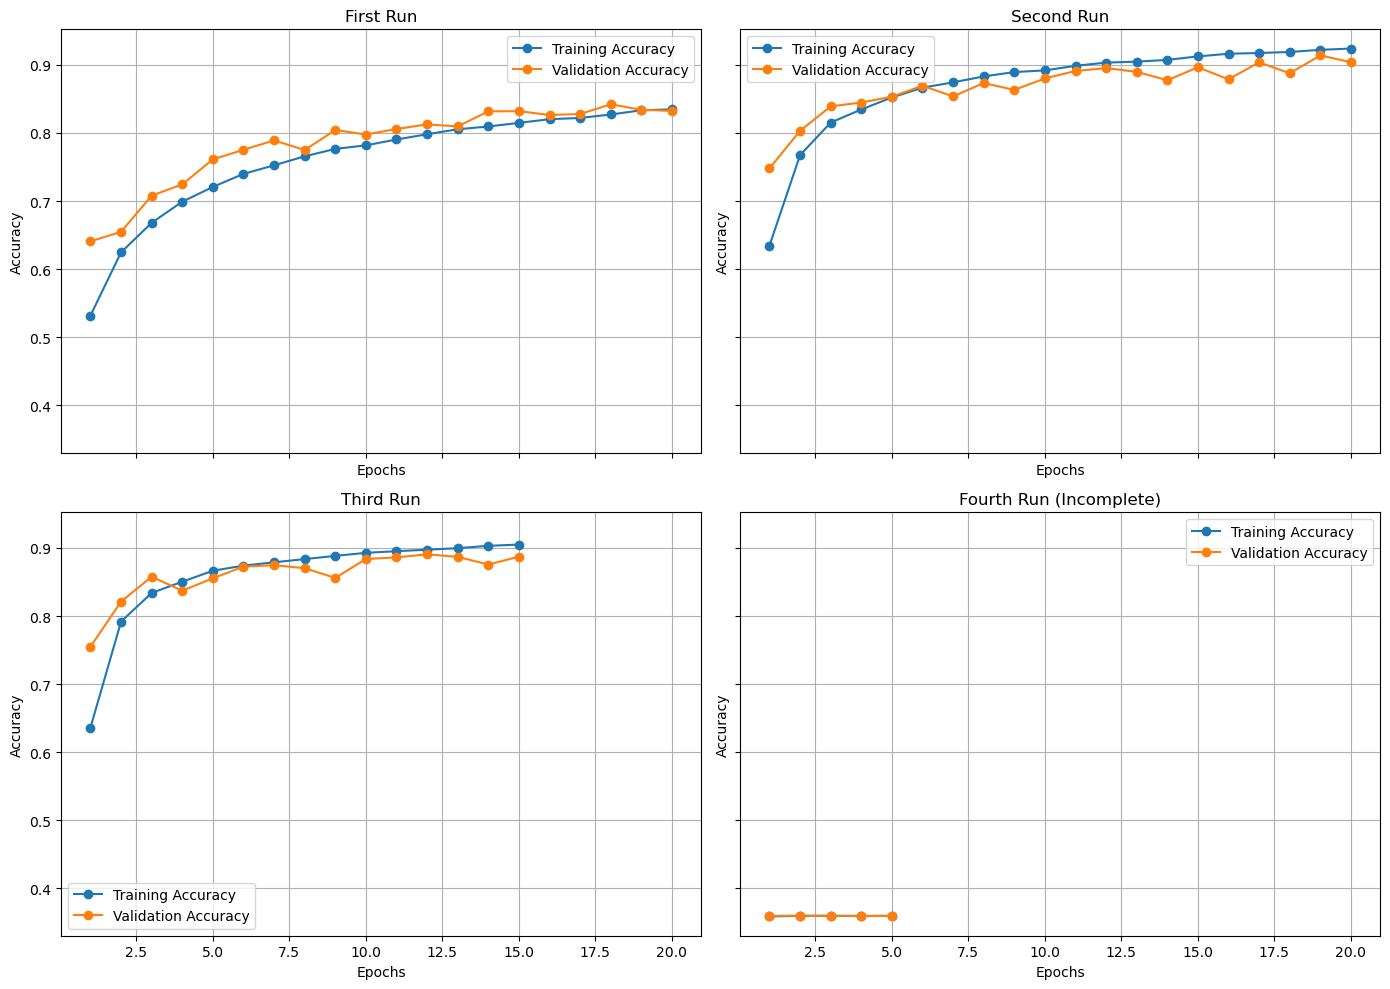

In [20]:
epochs = list(range(1, 21))

# First run (already used in the previous plot)
train_accuracy1 = [0.5319, 0.6247, 0.6681, 0.6991, 0.7207, 0.7399, 0.7525, 0.7657, 0.7766, 0.7818, 0.7904, 0.7981, 0.8054, 0.8095, 0.8148, 0.8202, 0.8220, 0.8271, 0.8333, 0.8347]
val_accuracy1 = [0.6408, 0.6549, 0.7079, 0.7245, 0.7612, 0.7753, 0.7891, 0.7749, 0.8043, 0.7977, 0.8058, 0.8126, 0.8096, 0.8317, 0.8320, 0.8264, 0.8278, 0.8421, 0.8340, 0.8324]

# Second run
train_accuracy2 = [0.6346, 0.7675, 0.8152, 0.8345, 0.8521, 0.8665, 0.8743, 0.8830, 0.8894, 0.8919, 0.8986, 0.9033, 0.9047, 0.9073, 0.9124, 0.9163, 0.9174, 0.9189, 0.9221, 0.9239]
val_accuracy2 = [0.7481, 0.8032, 0.8390, 0.8447, 0.8532, 0.8694, 0.8536, 0.8733, 0.8632, 0.8801, 0.8910, 0.8952, 0.8898, 0.8774, 0.8964, 0.8788, 0.9037, 0.8876, 0.9139, 0.9039]

# Third run
train_accuracy3 = [0.6362, 0.7919, 0.8339, 0.8504, 0.8665, 0.8740, 0.8789, 0.8836, 0.8883, 0.8928, 0.8952, 0.8974, 0.8996, 0.9031, 0.9049]
val_accuracy3 = [0.7549, 0.8212, 0.8577, 0.8371, 0.8555, 0.8725, 0.8747, 0.8702, 0.8560, 0.8837, 0.8861, 0.8906, 0.8869, 0.8756, 0.8872]

# Fourth run (incomplete)
train_accuracy4 = [0.3588, 0.3598, 0.3597, 0.3595, 0.3598]
val_accuracy4 = [0.3597, 0.3599, 0.3598, 0.3597, 0.3595]

# Plotting all four accuracies
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)


# First subplot
axes[0, 0].plot(epochs, train_accuracy1, label='Training Accuracy', marker='o')
axes[0, 0].plot(epochs, val_accuracy1, label='Validation Accuracy', marker='o')
axes[0, 0].set_title('1e-5 learning rate & 32 batch size')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Second subplot
axes[0, 1].plot(epochs, train_accuracy2, label='Training Accuracy', marker='o')
axes[0, 1].plot(epochs, val_accuracy2, label='Validation Accuracy', marker='o')
axes[0, 1].set_title('1e-4 learning rate & 32 batch size')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Third subplot
axes[1, 0].plot(epochs[:len(train_accuracy3)], train_accuracy3, label='Training Accuracy', marker='o')
axes[1, 0].plot(epochs[:len(val_accuracy3)], val_accuracy3, label='Validation Accuracy', marker='o')
axes[1, 0].set_title('1e-3 learning rate & 32 batch size')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Fourth subplot (limited data)
short_epochs = list(range(1, 6))  # Correcting the epoch range for the fourth run
axes[1, 1].plot(short_epochs, train_accuracy4, label='Training Accuracy', marker='o')
axes[1, 1].plot(short_epochs, val_accuracy4, label='Validation Accuracy', marker='o')
axes[1, 1].set_title('1e-2 learning rate & 32 batch size (Incomplete)')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Accuracy')

axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

Found 64827 images belonging to 6 classes.
Found 21607 images belonging to 6 classes.
Found 32470 images belonging to 6 classes.
Epoch 1/20


C:\Users\ROG\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1012/1012 ━━━━━━━━━━━━━━━━━━━━ 2956s 3s/step - accuracy: 0.4600 - loss: 1.3589 - val_accuracy: 0.6382 - val_loss: 0.9736
Epoch 2/20
   1/1012 ━━━━━━━━━━━━━━━━━━━━ 32:34 2s/step - accuracy: 0.6094 - loss: 1.0959

D:\Program Files\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1012/1012 ━━━━━━━━━━━━━━━━━━━━ 2s 386us/step - accuracy: 0.6094 - loss: 1.0959 - val_accuracy: 0.6410 - val_loss: 1.0238
Epoch 3/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 2830s 3s/step - accuracy: 0.6010 - loss: 1.0654 - val_accuracy: 0.6640 - val_loss: 0.9250
Epoch 4/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 2s 306us/step - accuracy: 0.5469 - loss: 1.0368 - val_accuracy: 0.6154 - val_loss: 0.8994
Epoch 5/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 2811s 3s/step - accuracy: 0.6435 - loss: 0.9730 - val_accuracy: 0.6794 - val_loss: 0.8629
Epoch 6/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 2s 302us/step - accuracy: 0.6250 - loss: 0.9877 - val_accuracy: 0.5385 - val_loss: 1.0445
Epoch 7/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 2804s 3s/step - accuracy: 0.6699 - loss: 0.8960 - val_accuracy: 0.7279 - val_loss: 0.7736
Epoch 8/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 2s 333us/step - accuracy: 0.7969 - loss: 0.6620 - val_accuracy: 0.7949 - val_loss: 0.6143
Epoch 9/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 2833s 3s/step - accuracy: 0.6880 - loss: 0.85

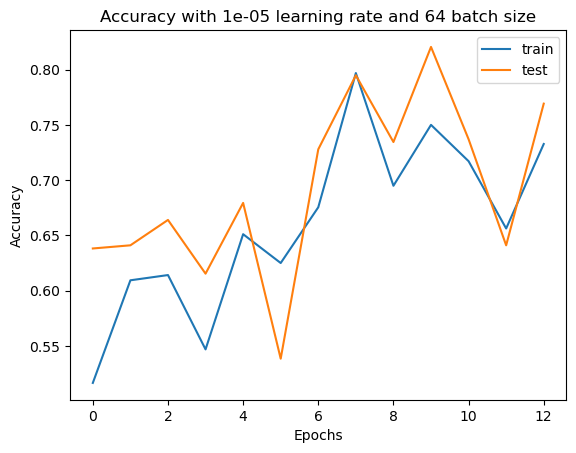

Epoch 1/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 2931s 3s/step - accuracy: 0.5397 - loss: 1.1806 - val_accuracy: 0.7330 - val_loss: 0.7180
Epoch 2/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 2s 318us/step - accuracy: 0.7812 - loss: 0.6521 - val_accuracy: 0.6923 - val_loss: 0.7553
Epoch 3/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 2889s 3s/step - accuracy: 0.7343 - loss: 0.7321 - val_accuracy: 0.7899 - val_loss: 0.5732


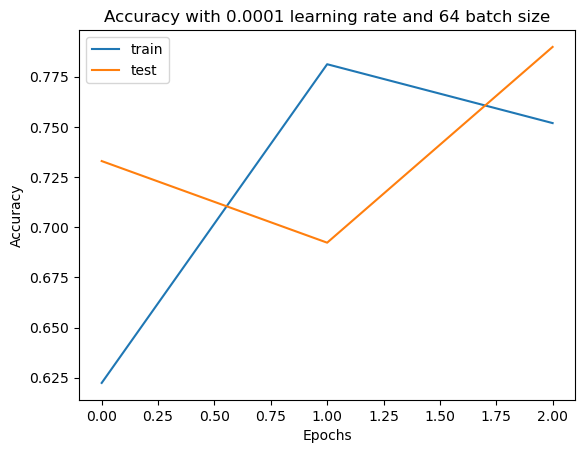

Epoch 1/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 2886s 3s/step - accuracy: 0.5605 - loss: 1.1660 - val_accuracy: 0.7680 - val_loss: 0.6392
Epoch 2/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 2s 328us/step - accuracy: 0.7188 - loss: 0.6899 - val_accuracy: 0.7949 - val_loss: 0.4652
Epoch 3/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 2889s 3s/step - accuracy: 0.7788 - loss: 0.6289 - val_accuracy: 0.8230 - val_loss: 0.5072
Epoch 4/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 2s 335us/step - accuracy: 0.8594 - loss: 0.4823 - val_accuracy: 0.8974 - val_loss: 0.3726
Epoch 5/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 2876s 3s/step - accuracy: 0.8368 - loss: 0.4727 - val_accuracy: 0.8383 - val_loss: 0.4663
Epoch 6/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 2s 310us/step - accuracy: 0.9375 - loss: 0.2709 - val_accuracy: 0.7179 - val_loss: 0.7039
Epoch 7/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 2885s 3s/step - accuracy: 0.8624 - loss: 0.4023 - val_accuracy: 0.8754 - val_loss: 0.3667


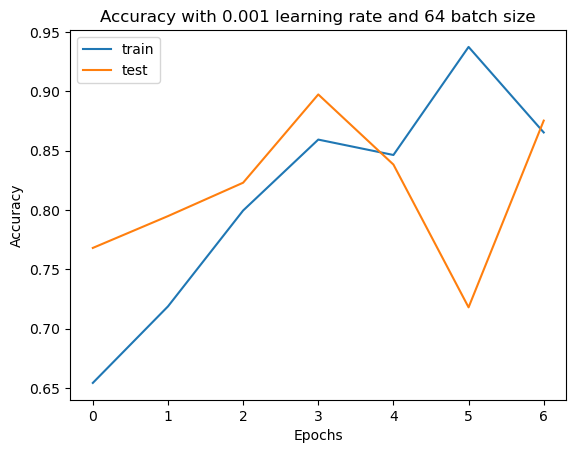

Epoch 1/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 2897s 3s/step - accuracy: 0.3518 - loss: 20.4603 - val_accuracy: 0.3604 - val_loss: 1.5736
Epoch 2/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 2s 311us/step - accuracy: 0.4062 - loss: 1.5572 - val_accuracy: 0.3590 - val_loss: 1.6246
Epoch 3/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 2910s 3s/step - accuracy: 0.3616 - loss: 1.5708 - val_accuracy: 0.3604 - val_loss: 1.5744


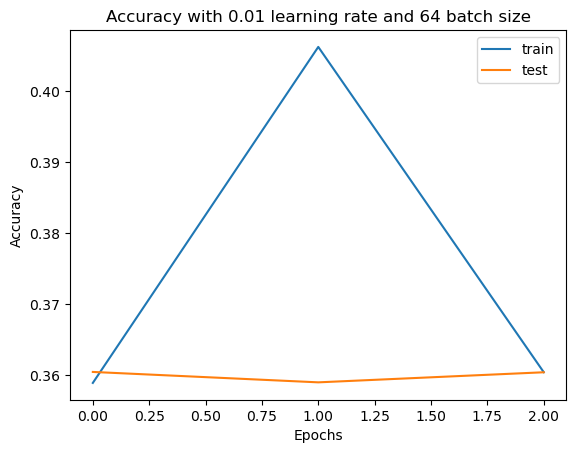

In [4]:
models = []
lr_boundary = [1e-5, 1e-4,1e-3,1e-2]

escape_for_loop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, restore_best_weights=True)

train64_generator = train_data_gen.flow_from_directory(
    training_dir,
    target_size=(image_size, image_size),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

valid64_generator = val_datagen.flow_from_directory(
    training_dir,
    target_size=(image_size, image_size),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

test64_generator = test_data_gen.flow_from_directory(
    testing_dir,
    target_size=(image_size, image_size),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

for learning_rate in lr_boundary:
    model = CNN_lR_batch(learning_rate, 6)
    tracking = model.fit(
    train64_generator,
    steps_per_epoch=train64_generator.n // 64,
    validation_data=valid64_generator,
    validation_steps=valid64_generator.n // 64,
    epochs=20,
    verbose=1, callbacks=[escape_for_loop]
    )

    plt.plot(tracking.history['accuracy'])
    plt.plot(tracking.history['val_accuracy'])
    plt.title('Accuracy with ' + str(learning_rate) + ' learning rate and ' + str(batch_size) +' batch size')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'test'])
    plt.show()
    models.append(model)
            
        
        

Found 54019 images belonging to 6 classes.
Found 18004 images belonging to 6 classes.
Found 18059 images belonging to 6 classes.
Epoch 1/20


C:\Users\ROG\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


422/422 ━━━━━━━━━━━━━━━━━━━━ 2904s 7s/step - accuracy: 0.4237 - loss: 1.4292 - val_accuracy: 0.6006 - val_loss: 1.0585
Epoch 2/20
  1/422 ━━━━━━━━━━━━━━━━━━━━ 31:26 4s/step - accuracy: 0.4375 - loss: 1.3228

D:\Program Files\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4375 - loss: 1.3228 - val_accuracy: 0.6071 - val_loss: 1.1150
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2443s 6s/step - accuracy: 0.5450 - loss: 1.1809 - val_accuracy: 0.6468 - val_loss: 0.9675
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5859 - loss: 1.0717 - val_accuracy: 0.6310 - val_loss: 0.9564
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2360s 6s/step - accuracy: 0.5901 - loss: 1.0894 - val_accuracy: 0.6237 - val_loss: 1.0300
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5547 - loss: 1.2421 - val_accuracy: 0.6071 - val_loss: 1.1486


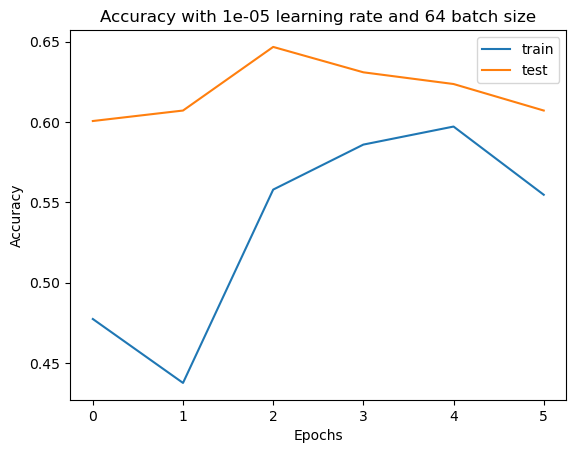

Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2367s 6s/step - accuracy: 0.4935 - loss: 1.2773 - val_accuracy: 0.6708 - val_loss: 0.8901
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6406 - loss: 0.8929 - val_accuracy: 0.6429 - val_loss: 0.9418
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2337s 6s/step - accuracy: 0.6693 - loss: 0.8953 - val_accuracy: 0.7242 - val_loss: 0.7236
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7891 - loss: 0.6152 - val_accuracy: 0.6548 - val_loss: 0.8752
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2341s 6s/step - accuracy: 0.7383 - loss: 0.7249 - val_accuracy: 0.7571 - val_loss: 0.6590
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7812 - loss: 0.6170 - val_accuracy: 0.7857 - val_loss: 0.6417
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2345s 6s/step - accuracy: 0.7754 - loss: 0.6377 - val_accuracy: 0.7983 - val_loss: 0.5589
Epoch 8/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8203 - loss: 0.4926 - val_accu

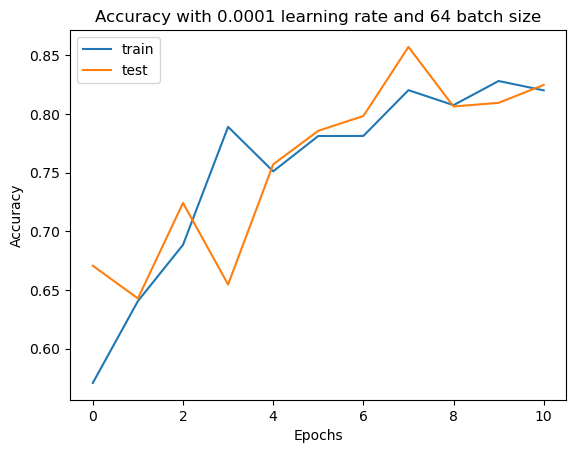

Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2380s 6s/step - accuracy: 0.4911 - loss: 1.3841 - val_accuracy: 0.6924 - val_loss: 0.8482
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7500 - loss: 0.7850 - val_accuracy: 0.7619 - val_loss: 0.8023
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2382s 6s/step - accuracy: 0.7369 - loss: 0.7336 - val_accuracy: 0.7549 - val_loss: 0.6807


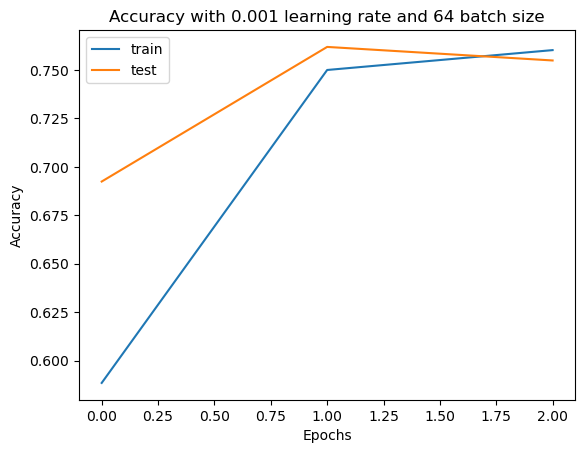

Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2412s 6s/step - accuracy: 0.3525 - loss: 13.2289 - val_accuracy: 0.3597 - val_loss: 1.5727
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3359 - loss: 1.5842 - val_accuracy: 0.3810 - val_loss: 1.6036
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2402s 6s/step - accuracy: 0.3571 - loss: 1.5729 - val_accuracy: 0.3601 - val_loss: 1.5738


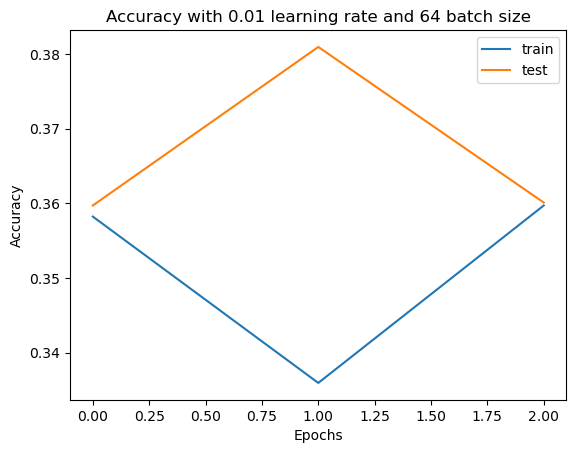

In [9]:
models = []
lr_boundary = [1e-5, 1e-4,1e-3,1e-2]

escape_for_loop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, restore_best_weights=True)

train128_generator = train_data_gen.flow_from_directory(
    training_dir,
    target_size=(image_size, image_size),
    batch_size=128,
    class_mode='categorical',
    subset='training'
)

valid128_generator = val_datagen.flow_from_directory(
    training_dir,
    target_size=(image_size, image_size),
    batch_size=128,
    class_mode='categorical',
    subset='validation'
)

test128_generator = test_data_gen.flow_from_directory(
    testing_dir,
    target_size=(image_size, image_size),
    batch_size=128,
    class_mode='categorical',
    shuffle=False
)

for learning_rate in lr_boundary:
    model = CNN_lR_batch(learning_rate, 6)
    tracking = model.fit(
    train128_generator,
    steps_per_epoch=train128_generator.n // 128,
    validation_data=valid128_generator,
    validation_steps=valid128_generator.n // 128,
    epochs=20,
    verbose=1, callbacks=[escape_for_loop]
    )

    plt.plot(tracking.history['accuracy'])
    plt.plot(tracking.history['val_accuracy'])
    plt.title('Accuracy with ' + str(learning_rate) + ' learning rate and ' + str(batch_size) +' batch size')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'test'])
    plt.show()
    models.append(model)
            
        
        

In [ ]:
models = []
lr_boundary = [1e-5, 1e-4,1e-3,1e-2]

escape_for_loop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, restore_best_weights=True)

train256_generator = train_data_gen.flow_from_directory(
    training_dir,
    target_size=(image_size, image_size),
    batch_size=256,
    class_mode='categorical',
    subset='training'
)

valid256_generator = val_datagen.flow_from_directory(
    training_dir,
    target_size=(image_size, image_size),
    batch_size=256,
    class_mode='categorical',
    subset='validation'
)

test256_generator = test_data_gen.flow_from_directory(
    testing_dir,
    target_size=(image_size, image_size),
    batch_size=256,
    class_mode='categorical',
    shuffle=False
)

for learning_rate in lr_boundary:
    model = CNN_lR_batch(learning_rate, 6)
    tracking = model.fit(
    train256_generator,
    steps_per_epoch=train256_generator.n // 256,
    validation_data=valid256_generator,
    validation_steps=valid256_generator.n // 256,
    epochs=20,
    verbose=1, callbacks=[escape_for_loop]
    )

    plt.plot(tracking.history['accuracy'])
    plt.plot(tracking.history['val_accuracy'])
    plt.title('Accuracy with ' + str(learning_rate) + ' learning rate and ' + str(batch_size) +' batch size')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'test'])
    plt.show()
    models.append(model)
            
        
        

Found 64827 images belonging to 6 classes.
Found 21607 images belonging to 6 classes.
Found 32470 images belonging to 6 classes.
Epoch 1/20


C:\Users\ROG\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 55/253 ━━━━━━━━━━━━━━━━━━━━ 2:08:32 39s/step - accuracy: 0.3447 - loss: 1.5720

In [5]:
def CNN_dropOut(dropOut, num_classes):
    model = Sequential()
    
    # Explicit Input layer
    model.add(Input(shape=(350, 350, 3)))
    
    # First convolutional layer
    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'))
    
    # Pooling layer
    model.add(MaxPooling2D(pool_size=(2,2)))
    

    # Additional convolutional and pooling layers
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(dropOut))

    model.add(Conv2D(filters=96, kernel_size=(3,3), padding='Same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(dropOut))
    

    model.add(Conv2D(filters=96, kernel_size=(3,3), padding='Same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(dropOut))
    

    # Flattening the output of the convolutional layers to feed into the dense layer
    model.add(Flatten())

    # Dense layer
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropOut))
    # Output layer with units equal to the number of categories
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model with updated optimizer syntax
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model



In [6]:
train32_generator = train_data_gen.flow_from_directory(
    training_dir,
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

valid32_generator = val_datagen.flow_from_directory(
    training_dir,
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test32_generator = test_data_gen.flow_from_directory(
    testing_dir,
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 65295 images belonging to 6 classes.
Found 21761 images belonging to 6 classes.
Found 34715 images belonging to 6 classes.


Epoch 1/20
2040/2040 [==============================] - 4865s 2s/step - loss: 1.0377 - accuracy: 0.6058 - val_loss: 0.8413 - val_accuracy: 0.6964
Epoch 2/20
2040/2040 [==============================] - 4307s 2s/step - loss: 0.7287 - accuracy: 0.7347 - val_loss: 0.6509 - val_accuracy: 0.7795
Epoch 3/20
2040/2040 [==============================] - 4313s 2s/step - loss: 0.5851 - accuracy: 0.7938 - val_loss: 0.5209 - val_accuracy: 0.8276
Epoch 4/20
2040/2040 [==============================] - 4293s 2s/step - loss: 0.5128 - accuracy: 0.8224 - val_loss: 0.4692 - val_accuracy: 0.8408
Epoch 5/20
2040/2040 [==============================] - 4308s 2s/step - loss: 0.4679 - accuracy: 0.8391 - val_loss: 0.4087 - val_accuracy: 0.8652
Epoch 6/20
2040/2040 [==============================] - 4271s 2s/step - loss: 0.4358 - accuracy: 0.8515 - val_loss: 0.4056 - val_accuracy: 0.8648
Epoch 7/20
2040/2040 [==============================] - 4344s 2s/step - loss: 0.4093 - accuracy: 0.8586 - val_loss: 0.3782 -

NameError: name 'dr' is not defined

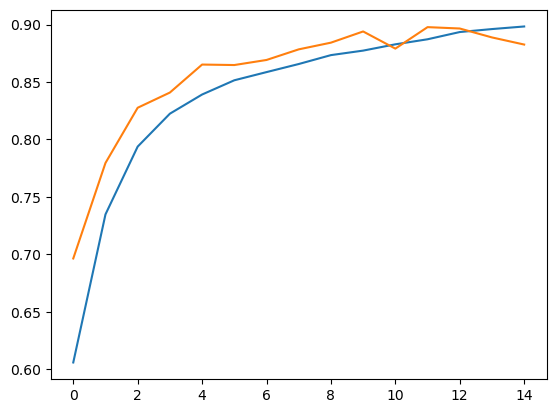

In [7]:
models = []
dropOut_boundary = [0.2, 0.5, 0.3]
# check the batch size and learning rate, and complete the model before training
escape_for_loop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, restore_best_weights=True)


model = CNN_dropOut(0.2, 6)
tracking = model.fit(
train32_generator,
steps_per_epoch=train32_generator.n // 32,
validation_data=valid32_generator,
validation_steps=valid32_generator.n // 32,
epochs=20,
verbose=1, callbacks=[escape_for_loop]
)

plt.plot(tracking.history['accuracy'])
plt.plot(tracking.history['val_accuracy'])
plt.title('Accuracy with ' + str(0.2) +' drop out ')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()
            
        
        

In [ ]:
model = CNN_dropOut(0.4, 6)
tracking = model.fit(
train32_generator,
steps_per_epoch=train32_generator.n // 32,
validation_data=valid32_generator,
validation_steps=valid32_generator.n // 32,
epochs=20,
verbose=1, callbacks=[escape_for_loop]
)

plt.plot(tracking.history['accuracy'])
plt.plot(tracking.history['val_accuracy'])
plt.title('Accuracy with ' + str(0.4) +' drop out ')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()
models.append(model)

Epoch 1/20
 850/2040 [===========>..................] - ETA: 41:57 - loss: 1.3278 - accuracy: 0.4728

In [ ]:
model = CNN_dropOut(0.5, 6)
    tracking = model.fit(
    train32_generator,
    steps_per_epoch=train32_generator.n // 32,
    validation_data=valid32_generator,
    validation_steps=valid32_generator.n // 32,
    epochs=20,
    verbose=1, callbacks=[escape_for_loop]
    )

    plt.plot(tracking.history['accuracy'])
    plt.plot(tracking.history['val_accuracy'])
    plt.title('Accuracy with ' + str(dr) +' drop out ')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'test'])
    plt.show()
    models.append(model)